In [1]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as sp
%load_ext google.cloud.bigquery
import pickle
from matplotlib import pyplot as plt
from datetime import datetime
with open('design.pkl','rb') as f:
    set_params = pickle.load(f)
plt.rcParams.update(set_params)

In [2]:

# Modules
from modules.connector import MyBigQuery, MySQL

In [3]:
bq = MyBigQuery(
    credentials_file="./credentials/New AutoMotive Index-487e031dc242.json"
)

In [4]:
def ft_cleaner(x):
    x = x.replace('GAS BI-FUEL', 'Other').replace('GAS', 'Other').replace('GAS DIESEL', 'Other').replace('PETROL/GAS', 'Other').replace('LPG', 'Other').replace('STEAM', 'Other').replace('LNG', 'Other').replace('OTHER', 'Other').replace('CNG', 'Other')
    x = x.replace('FUEL CELLS', 'Other')
    x = x.replace('PETROL', 'Petrol').replace('Petrol/Other', 'Petrol')
    x = x.replace('HYBRID ELECTRIC (CLEAN)', 'Hybrid').replace('HYBRID ELECTRIC', 'Hybrid').replace('ELECTRIC DIESEL', 'Hybrid')
    x = x.replace('DIESEL', 'Diesel').replace('Other Diesel', 'Diesel')
    x = x.replace('ELECTRICITY', 'Pure Electric').replace('ELECTRIC', 'Pure Electric')
    return x

In [5]:
this_month = datetime.today().strftime(format='%Y-%m')

In [22]:
datetime.today().month

5

In [24]:
last_month = datetime.today().replace(month=datetime.today().month-1).strftime(format='%Y-%m')

In [6]:
%%bigquery car_targets --project rugged-baton-283921
SELECT make, AVG(co2Emissions) as co2Target
FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'
AND monthOfFirstRegistration > '2020-12-31'
AND monthOfFirstRegistration < '2022-01-01'
AND co2Emissions > 0
GROUP BY make

Downloading: 100%|██████████| 88/88 [00:01<00:00, 77.72rows/s]


In [7]:
# car_targets.sort_values('meanCo2').plot(kind='bar', x='make', figsize=(40, 10))

In [8]:
%%bigquery df_activity --project rugged-baton-283921
SELECT 
    make, 
    COUNT(*) as totalSales,
    COUNTIF(co2Emissions > 0) as nonzevSales,
    COUNTIF(co2Emissions = 0) as zevSales,
    SUM(co2Emissions) as co2Activity

FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'
AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
AND make IN (
    SELECT make
    FROM VES_dataset.VRN_UK
    WHERE typeApproval = 'M1'
    AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    -- AND total > 2500
    GROUP BY make
    HAVING COUNT(*) > 2500
)
GROUP BY make
ORDER BY totalSales ASC;

Downloading: 100%|██████████| 32/32 [00:02<00:00, 14.62rows/s]


In [9]:
dfa = df_activity.merge(car_targets, how='left', on='make')
dfa['co2Allowances'] = dfa.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
dfa['co2Compliance'] = dfa.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)

In [10]:
mandate =.22

In [11]:
def co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2Compliance / 167
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    return new_zev_credits
        
def proposed_co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    conversion_factor = row.co2Target
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2Compliance / conversion_factor
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    return new_zev_credits


In [12]:
dfa['co2_to_mandate_allowances'] = dfa.apply(lambda row: co2_to_zev(row, mandate=mandate), axis=1)
dfa['proposed_co2_to_mandate_allowances'] = dfa.apply(lambda row: proposed_co2_to_zev(row, mandate=mandate), axis=1)


In [13]:
dfa

,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance,co2_to_mandate_allowances,proposed_co2_to_mandate_allowances
0,JEEP,2677,2677,0,273090.0,163.147143,4.367449e+05,163654.901429,147.235000,147.235000
1,DS,3673,3000,673,332578.0,123.471191,3.704136e+05,37835.572343,202.015000,202.015000
2,LEXUS,8835,8373,462,1001276.0,150.771893,1.262413e+06,261137.061501,485.925000,485.925000
3,JAGUAR,9971,6116,3855,987936.0,174.370883,1.066452e+06,78516.318492,470.157596,450.283426
4,POLESTAR,10043,2,10041,26.0,192.000000,3.840000e+02,358.000000,2.143713,1.864583
5,PORSCHE,14845,10766,4079,2321349.0,219.338652,2.361400e+06,40050.932624,239.825944,182.598608
6,CUPRA,17496,11647,5849,1783864.0,118.189238,1.376550e+06,-407313.944522,0.000000,0.000000
7,SUZUKI,17585,17585,0,2069009.0,117.627482,2.068479e+06,-529.735917,0.000000,0.000000
8,HONDA,21588,21273,315,2593297.0,124.831125,2.655533e+06,62235.522125,372.667797,498.557728
9,FIAT,22007,16609,5398,2072593.0,130.535102,2.168058e+06,95464.503635,571.643734,731.332051


In [14]:
mandate = .22
dfa['ZEVMallowances'] = dfa.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
dfa['ZEV Surplus'] = dfa.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
dfa['ZEV Surplus after CO2'] = dfa.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)
dfa['ZEV Surplus after CO2 - Proposed'] = dfa.apply(lambda row: row['ZEV Surplus'] + row.proposed_co2_to_mandate_allowances, axis=1)

In [15]:
(1 - (mandate * .25)) * 135525

128071.125

In [16]:
dfa[dfa.make == 'VOLKSWAGEN']

,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance,co2_to_mandate_allowances,proposed_co2_to_mandate_allowances,ZEVMallowances,ZEV Surplus,ZEV Surplus after CO2,ZEV Surplus after CO2 - Proposed
31,VOLKSWAGEN,143624,119893,23731,16034084.0,139.80966,1.676220e+07,728115.558013,4359.973401,5207.905937,112026.72,-7866.28,-3506.306599,-2658.374063


<ipython-input-28-2a55e6cc3ce6>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolorcolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('plots/top_20_last_12_months_{}.png'.format(this_month), transparent=False, bbox_inches='tight', dpi=300, edgecolorcolor='white', facecolor='white')


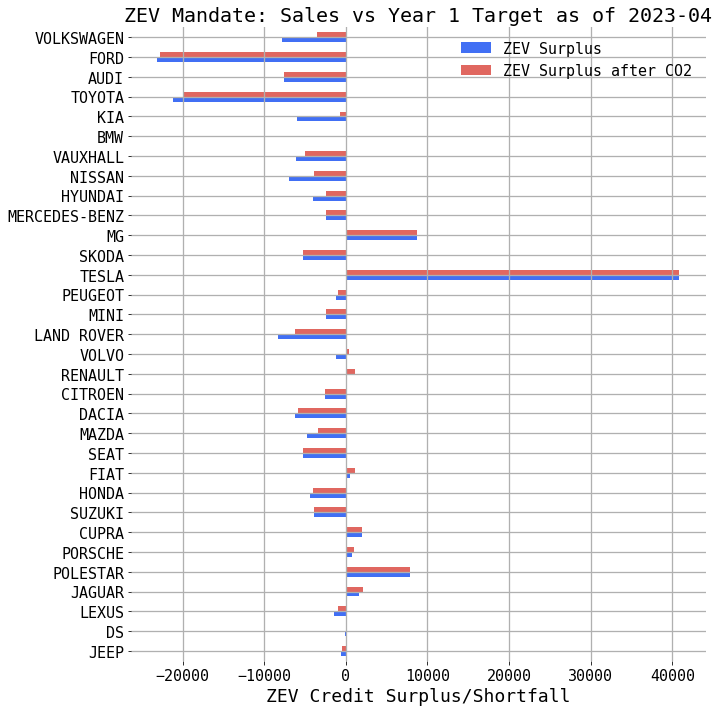

In [28]:
fig, ax = plt.subplots()

dfa.plot(x='make', y=[
    'ZEV Surplus', 
    'ZEV Surplus after CO2', 
    # 'ZEV Surplus after CO2 - Proposed'
], kind='barh', ax=ax, figsize=(10, 10))
ax.set_xlabel('ZEV Credit Surplus/Shortfall')
ax.set_ylabel('')

ax.set_title('ZEV Mandate: Sales vs Year 1 Target as of {}'.format(last_month))

plt.savefig('plots/top_20_last_12_months_{}.png'.format(this_month), transparent=False, bbox_inches='tight', dpi=300, facecolor='white')
plt.show()

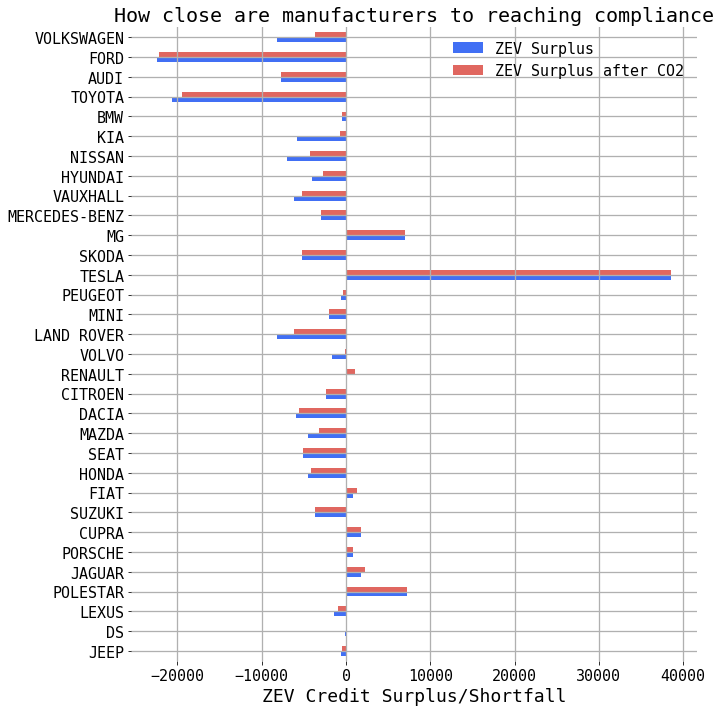

In [14]:
# fig, ax = plt.subplots()

# dfa.plot(x='make', y=[
#     'ZEV Surplus', 
#     'ZEV Surplus after CO2', 
#     # 'ZEV Surplus after CO2 - Proposed'
# ], kind='barh', ax=ax, figsize=(10, 10))
# ax.set_xlabel('ZEV Credit Surplus/Shortfall')
# ax.set_ylabel('')

# ax.set_title('How close are manufacturers to reaching compliance')

# plt.savefig('plots/top_20_last_12_months.png', transparent=False, bbox_inches='tight', dpi=300)
# plt.show()

In [27]:
dfa['CO2 Performance'] = dfa.co2Activity / dfa.nonzevSales

In [28]:
dfa_sel = dfa[[
    'make',
    'totalSales',
    'nonzevSales',
    'zevSales',
    'co2Target',
    'CO2 Performance',
    'ZEVMallowances',
    'ZEV Surplus',
    'ZEV Surplus after CO2'
]].rename(columns={
    'make': 'Make',
    'totalSales': 'Total Sales',
    'co2Target': 'CO2 Target',
    'nonzevSales': 'Non-ZEV Sales',
    'zevSales': 'ZEV Sales',
    'ZEVMallowances': 'Allocated allowances',
    'ZEV Surplus': 'Allowance Surplus',
    'ZEV Surplus after CO2': 'Allowance Surplus (after CO2 transfers)'
})

# dfa_sel['Mean CO2'] = 
dfa_sel = round(dfa_sel, ndigits=2)

dfa_sel = dfa_sel.sort_values('Total Sales', ascending=False)

In [29]:
dfa_sel.to_csv('ZEV_compliance_tracker.csv')

# Rolling Performance

In [65]:
%%bigquery df_act --project rugged-baton-283921
SELECT 
    VES.make,
    VES.monthOfFirstRegistration,
    COUNT(*) as totalSales,
    COUNTIF(VES.co2Emissions > 0) as nonzevSales,
    COUNTIF(VES.co2Emissions = 0) as zevSales,
    SUM(VES.co2Emissions) as co2Activity

FROM VES_dataset.VRN_UK VES
WHERE typeApproval = 'M1'
AND CAST(monthOfFirstRegistration AS DATE) > '2020-03-31'
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
# AND make IN (
#     SELECT make
#     FROM VES_dataset.VRN_UK
#     WHERE typeApproval = 'M1'
#     AND monthOfFirstRegistration > '2020-03-31'
#     AND monthOfFirstRegistration < '2023-04-01'
#     GROUP BY make
#     ORDER BY COUNT(*) DESC
#     LIMIT 20
    
# )

# Volume limit
AND make IN (
    SELECT make
    FROM VES_dataset.VRN_UK
    WHERE typeApproval = 'M1'
    AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    -- AND total > 2500
    GROUP BY make
    HAVING COUNT(*) > 2500
)



GROUP BY make, monthofFirstRegistration
ORDER BY totalSales ASC;

Downloading: 100%|██████████| 1173/1173 [00:00<00:00, 1408.22rows/s]


In [66]:
# If we want to filter out all but the top five/ten/twenty makes, we can use this
top_makes = df_act.groupby('make').sum().sort_values('totalSales', ascending=False).index.tolist()[:10]

In [67]:
# Make a copy to edit
df = df_act.copy()#.merge(car_targets, how='left', on='make')

In [68]:
df.head()

,make,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity
0,DS,2020-04-01 00:00:00+00:00,1,0,1,0.0
1,TESLA,2022-07-01 00:00:00+00:00,2,0,2,0.0
2,SUZUKI,2020-04-01 00:00:00+00:00,5,5,0,613.0
3,JEEP,2020-04-01 00:00:00+00:00,5,5,0,1145.0
4,HONDA,2020-04-01 00:00:00+00:00,7,6,1,930.0


In [69]:
# This turns our numbers into 12 month rolling totals/averages

dfs = []
makes = df.make.unique().tolist()

for make in makes:
    temp_df = df[df.make == make].set_index('monthOfFirstRegistration').sort_index().rolling(12).sum()
    temp_df = temp_df.reset_index().dropna()
    temp_df['make'] = make
    dfs.append(temp_df)
    
df = pd.concat(dfs)

In [70]:
# This gives us the targets for CO2 performance
df = df.reset_index().merge(car_targets, how='left', on='make')

In [71]:
df['co2Allowances'] = df.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
df['co2Compliance'] = df.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)
df['co2_to_mandate_allowances'] = df.apply(lambda row: co2_to_zev(row, mandate=.22), axis=1)
# df['proposed_co2_to_mandate_allowances'] = df.apply(lambda row: proposed_co2_to_zev(row,), axis=1)

In [72]:
mandate = .22
df['ZEVMallowances'] = df.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
df['ZEV Surplus'] = df.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
df['ZEV Surplus after CO2'] = df.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)
# df['ZEV Surplus after CO2 - Proposed'] = df.apply(lambda row: row['ZEV Surplus'] + row.proposed_co2_to_mandate_allowances, axis=1)

In [73]:
# Are there any manufacturers failing to make Co2 compliance but with surplus ZEV credits, who would need to transfer ZEV credits into the regime 
# We assume that manufacturers would rather transfer from CO2 than purchase CO2 allowances. 
# df[(df['ZEV Surplus'] > 0) & (df.co2Compliance < 0)]

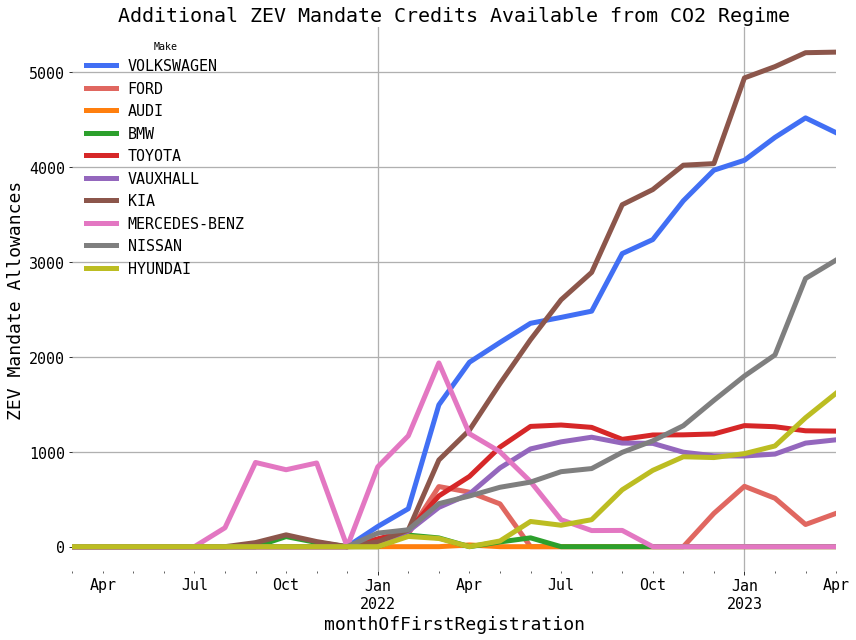

In [74]:
fig, ax = plt.subplots()

df.pivot(index='monthOfFirstRegistration', columns='make', values='co2_to_mandate_allowances')[top_makes].plot(ax=ax)
ax.set_ylabel('ZEV Mandate Allowances')
ax.legend(title='Make', loc='upper left')
ax.set_title('Additional ZEV Mandate Credits Available from CO2 Regime')

plt.show()

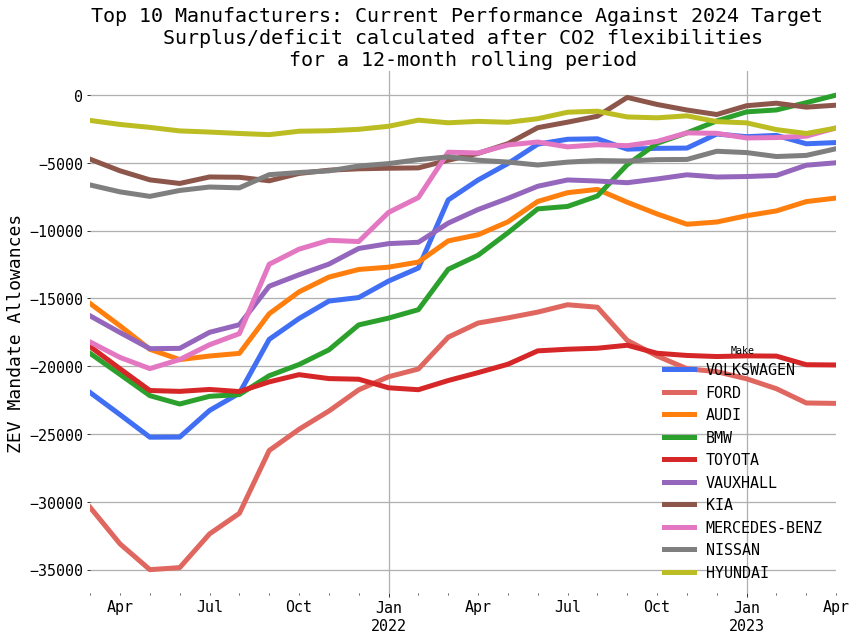

In [75]:
fig, ax = plt.subplots()

df.pivot(index='monthOfFirstRegistration', columns='make', values='ZEV Surplus after CO2')[top_makes].plot(ax=ax)
ax.set_ylabel('ZEV Mandate Allowances')
ax.set_xlabel('')
ax.set_title('Top 10 Manufacturers: Current Performance Against 2024 Target \n Surplus/deficit calculated after CO2 flexibilities \nfor a 12-month rolling period')
ax.legend(title='Make', loc='lower right')

plt.savefig('plots/top_10_manufacturers_zevm.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [76]:
dfa

,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance,co2_to_mandate_allowances,proposed_co2_to_mandate_allowances,ZEVMallowances,ZEV Surplus,ZEV Surplus after CO2,ZEV Surplus after CO2 - Proposed,CO2 Performance
0,JEEP,2677,2677,0,273090.0,163.147143,4.367449e+05,163654.901429,147.235000,147.235000,2088.06,-588.94,-441.705000,-441.705000,102.013448
1,DS,3673,3000,673,332578.0,123.471191,3.704136e+05,37835.572343,202.015000,202.015000,2864.94,-135.06,66.955000,66.955000,110.859333
2,LEXUS,8835,8373,462,1001276.0,150.771893,1.262413e+06,261137.061501,485.925000,485.925000,6891.30,-1481.70,-995.775000,-995.775000,119.583901
3,JAGUAR,9971,6116,3855,987936.0,174.370883,1.066452e+06,78516.318492,470.157596,450.283426,7777.38,1661.38,2131.537596,2111.663426,161.533028
4,POLESTAR,10043,2,10041,26.0,192.000000,3.840000e+02,358.000000,2.143713,1.864583,7833.54,7831.54,7833.683713,7833.404583,13.000000
5,PORSCHE,14845,10766,4079,2321349.0,219.338652,2.361400e+06,40050.932624,239.825944,182.598608,11579.10,813.10,1052.925944,995.698608,215.618521
6,CUPRA,17496,11647,5849,1783864.0,118.189238,1.376550e+06,-407313.944522,0.000000,0.000000,13646.88,1999.88,1999.880000,1999.880000,153.160814
7,SUZUKI,17585,17585,0,2069009.0,117.627482,2.068479e+06,-529.735917,0.000000,0.000000,13716.30,-3868.70,-3868.700000,-3868.700000,117.657606
8,HONDA,21588,21273,315,2593297.0,124.831125,2.655533e+06,62235.522125,372.667797,498.557728,16838.64,-4434.36,-4061.692203,-3935.802272,121.905561
9,FIAT,22007,16609,5398,2072593.0,130.535102,2.168058e+06,95464.503635,571.643734,731.332051,17165.46,556.46,1128.103734,1287.792051,124.787344


In [83]:
df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2'].diff()

monthOfFirstRegistration
2021-03-01 00:00:00+00:00             NaN
2021-04-01 00:00:00+00:00   -23068.556664
2021-05-01 00:00:00+00:00   -17906.168470
2021-06-01 00:00:00+00:00     3600.579087
2021-07-01 00:00:00+00:00    13035.470034
2021-08-01 00:00:00+00:00     5993.761171
2021-09-01 00:00:00+00:00    35570.546024
2021-10-01 00:00:00+00:00    12914.754177
2021-11-01 00:00:00+00:00    11151.057855
2021-12-01 00:00:00+00:00     9504.298490
2022-01-01 00:00:00+00:00     6880.213776
2022-02-01 00:00:00+00:00     7157.344653
2022-03-01 00:00:00+00:00    32812.877671
2022-04-01 00:00:00+00:00     9427.728541
2022-05-01 00:00:00+00:00    11134.005589
2022-06-01 00:00:00+00:00    13342.158329
2022-07-01 00:00:00+00:00     4547.095815
2022-08-01 00:00:00+00:00     2834.831396
2022-09-01 00:00:00+00:00     4910.931902
2022-10-01 00:00:00+00:00     -788.007389
2022-11-01 00:00:00+00:00     2882.839108
2022-12-01 00:00:00+00:00    10927.700601
2023-01-01 00:00:00+00:00     1238.235948
2023-02-0

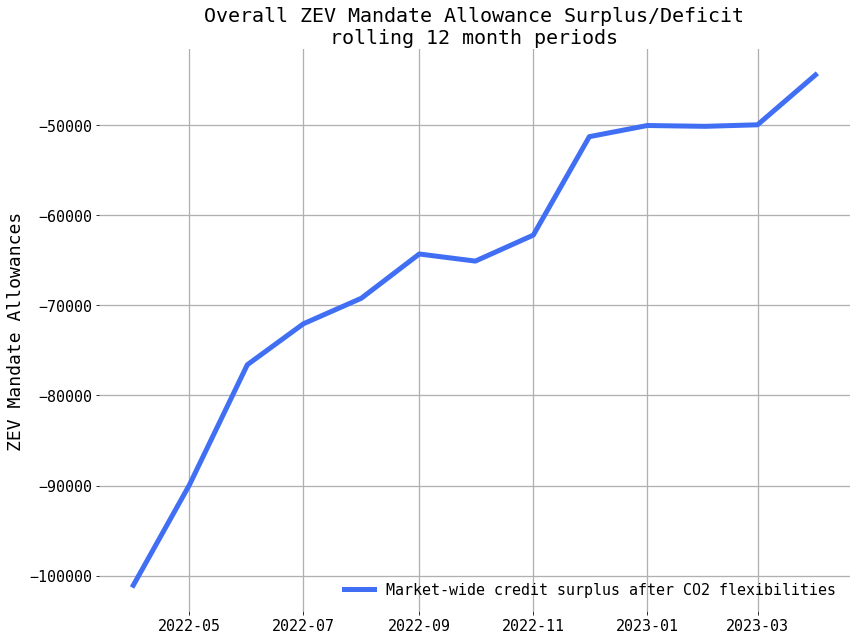

In [82]:
fig, ax = plt.subplots()

# ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus'], label='Market-wide credit surplus')
plt_df = df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2']

ax.plot(plt_df[plt_df.index > '2022-03-01'], label='Market-wide credit surplus after CO2 flexibilities')
# ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2 - Proposed'], label='Proposed Market-wide credit surplus after CO2 flexibilities')
ax.set_ylabel('ZEV Mandate Allowances')

# ax.legend(loc='lower right')
ax.set_title('Overall ZEV Mandate Allowance Surplus/Deficit\nrolling 12 month periods')
ax.legend(loc='lower right')

plt.savefig('plots/aggregate_demand_credits_{}.png'.format(this_month), transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [43]:
df['meanCo2'] = df.apply(lambda row: row.co2Activity / row.nonzevSales if row.nonzevSales >0 else np.nan , axis=1)

In [44]:
car_targets[car_targets.make.isin(top_makes)]

,make,co2Target
18,MERCEDES-BENZ,137.089305
45,AUDI,141.996932
46,BMW,130.073990
49,NISSAN,142.631666
50,FORD,127.002661
57,VOLKSWAGEN,139.809660
63,HYUNDAI,127.236825
64,VAUXHALL,127.637327
77,KIA,135.698205
79,TOYOTA,110.471413


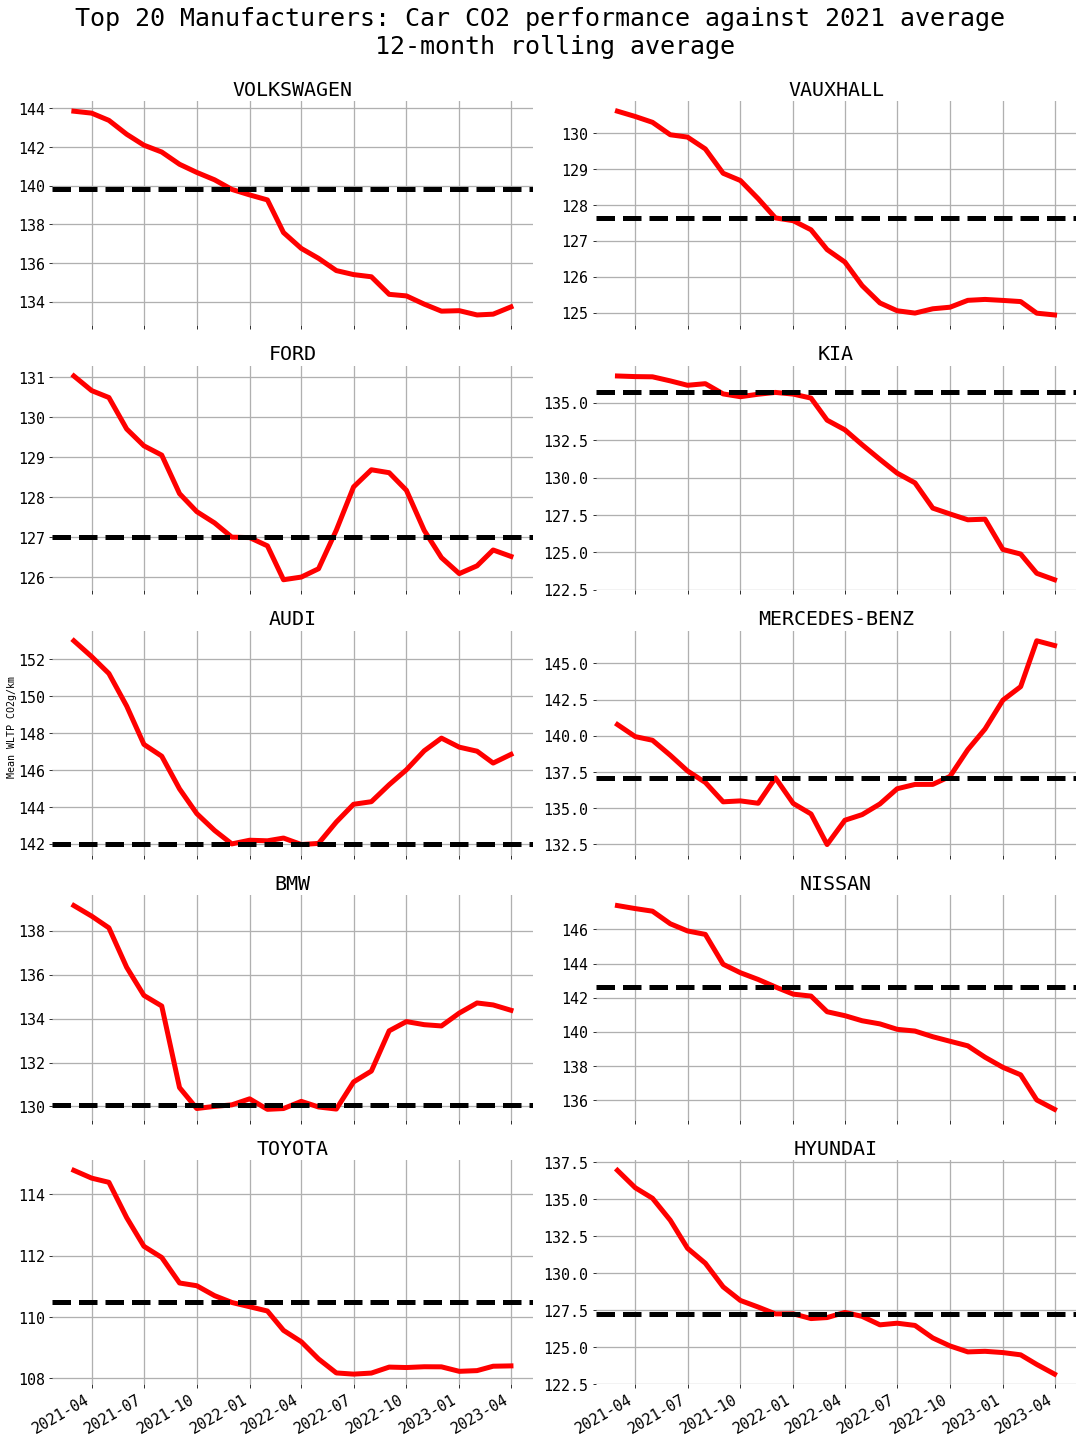

In [45]:
fig, ax = plt.subplots(5, 2, figsize=(15, 20))

# # df.pivot(index='monthOfFirstRegistration', columns='make', values='meanCo2')[top_makes].plot(ax=ax)
# # ax.axhline(car_targets[car_targets.make.isin(top_makes)])
# # ax.set_xlabel('')
# # ax.legend(title='Make', loc='lower right')

plt_df = df.pivot(index='monthOfFirstRegistration', columns='make', values='meanCo2')[top_makes]



for e, make in enumerate(top_makes[:5]):
    ax[e, 0].plot(plt_df[make], c='red')
    ax[e, 0].axhline(car_targets[car_targets.make == make].co2Target.values, c='black', linestyle='--')
    ax[e, 0].set_title(make)
    ax[e, 0].figure.autofmt_xdate()
    # ax[e, 0].set_ylabel('Mean WLPT CO2g/km')
    
for e, make in enumerate(top_makes[5:]):
    ax[e, 1].plot(plt_df[make], c='red')
    ax[e, 1].axhline(car_targets[car_targets.make == make].co2Target.values, c='black', label='2021 Baseline Target', linestyle='--')
    ax[e, 1].set_title(make)
    ax[e, 1].figure.autofmt_xdate()
    # ax[e, 1].set_ylabel('Mean WLPT CO2g/km')
    

fig.text(0.0, 0.5, 'Mean WLTP CO2g/km', va='center', rotation='vertical', fontsize=10)
fig.suptitle('Top 20 Manufacturers: Car CO2 performance against 2021 average \n 12-month rolling average', y=1, fontsize=25)
fig.tight_layout()
# plt.show()

plt.savefig('plots/co2.png', transparent=False, bbox_inches='tight', dpi=300)

# ax[0, 0]

In [8]:
#A function to calculate CO2 flexibilities
def co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2Compliance / 167
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    return new_zev_credits

In [9]:
targets = bq.from_bq_to_dataframe(
    query="""
    SELECT make, AVG(co2Emissions) as co2Target
    FROM VES_dataset.VRN_UK
    WHERE typeApproval = 'M1'
    AND monthOfFirstRegistration > '2020-12-31'
    AND monthOfFirstRegistration < '2022-01-01'
    AND co2Emissions > 0
    AND make IN (
        SELECT make
        FROM VES_dataset.VRN_UK
        WHERE typeApproval = 'M1'
        AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
        AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
        -- AND total >= 2500
        GROUP BY make
        HAVING COUNT(*) >= 2500
    )
    
    GROUP BY make
    """)

In [12]:
activity = bq.from_bq_to_dataframe(
    query = """
    SELECT 
        VES.make,
        VES.monthOfFirstRegistration,
        COUNT(*) as totalSales,
        COUNTIF(VES.co2Emissions > 0) as nonzevSales,
        COUNTIF(VES.co2Emissions = 0) as zevSales,
        SUM(VES.co2Emissions) as co2Activity

    FROM VES_dataset.VRN_UK VES
    WHERE typeApproval = 'M1'
    AND CAST(monthOfFirstRegistration AS DATE) > '2020-03-31'
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    
    # Volume limit
    AND make IN (
        SELECT make
        FROM VES_dataset.VRN_UK
        WHERE typeApproval = 'M1'
        AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
        AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
        -- AND total > 2500
        GROUP BY make
        HAVING COUNT(*) > 2500
    )



    GROUP BY make, monthofFirstRegistration
    ORDER BY totalSales ASC;

    """

)

In [14]:
dfs = []
makes = activity.make.unique().tolist()

for make in makes:

    temp_df = activity[(activity.make == make)].set_index('monthOfFirstRegistration').sort_index().rolling(12).sum()
    temp_df = temp_df.reset_index().dropna()
    temp_df['make'] = make
    dfs.append(temp_df)
    
activity = pd.concat(dfs)

In [21]:
# To calculate the CO2 flex that comes from rUK, we need to use the function above. We'll take a look at the whole of the UK's additional CO2 -> ZEV credits

ukevs = activity.groupby(['monthOfFirstRegistration', 'make']).sum().reset_index()

# First, we bring in the targets
ukevs = ukevs.merge(targets, how='left', on='make')

# then we calculate CO2 allowances
ukevs['co2Allowances'] = ukevs.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
ukevs['co2Compliance'] = ukevs.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)

# How many available for transfer
ukevs['co2_to_mandate_allowances'] = ukevs.apply(lambda row: co2_to_zev(row, mandate=.22), axis=1)

# Then, the mandate
mandate = .22
ukevs['ZEVMallowances'] = ukevs.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
ukevs['ZEV Surplus'] = ukevs.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
ukevs['ZEV Surplus after CO2'] = ukevs.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)

ukevs['mean_co2'] = ukevs.co2Activity / ukevs.nonzevSales


In [27]:
len(ukevs.make.unique())

32

Error with 5: list index out of range


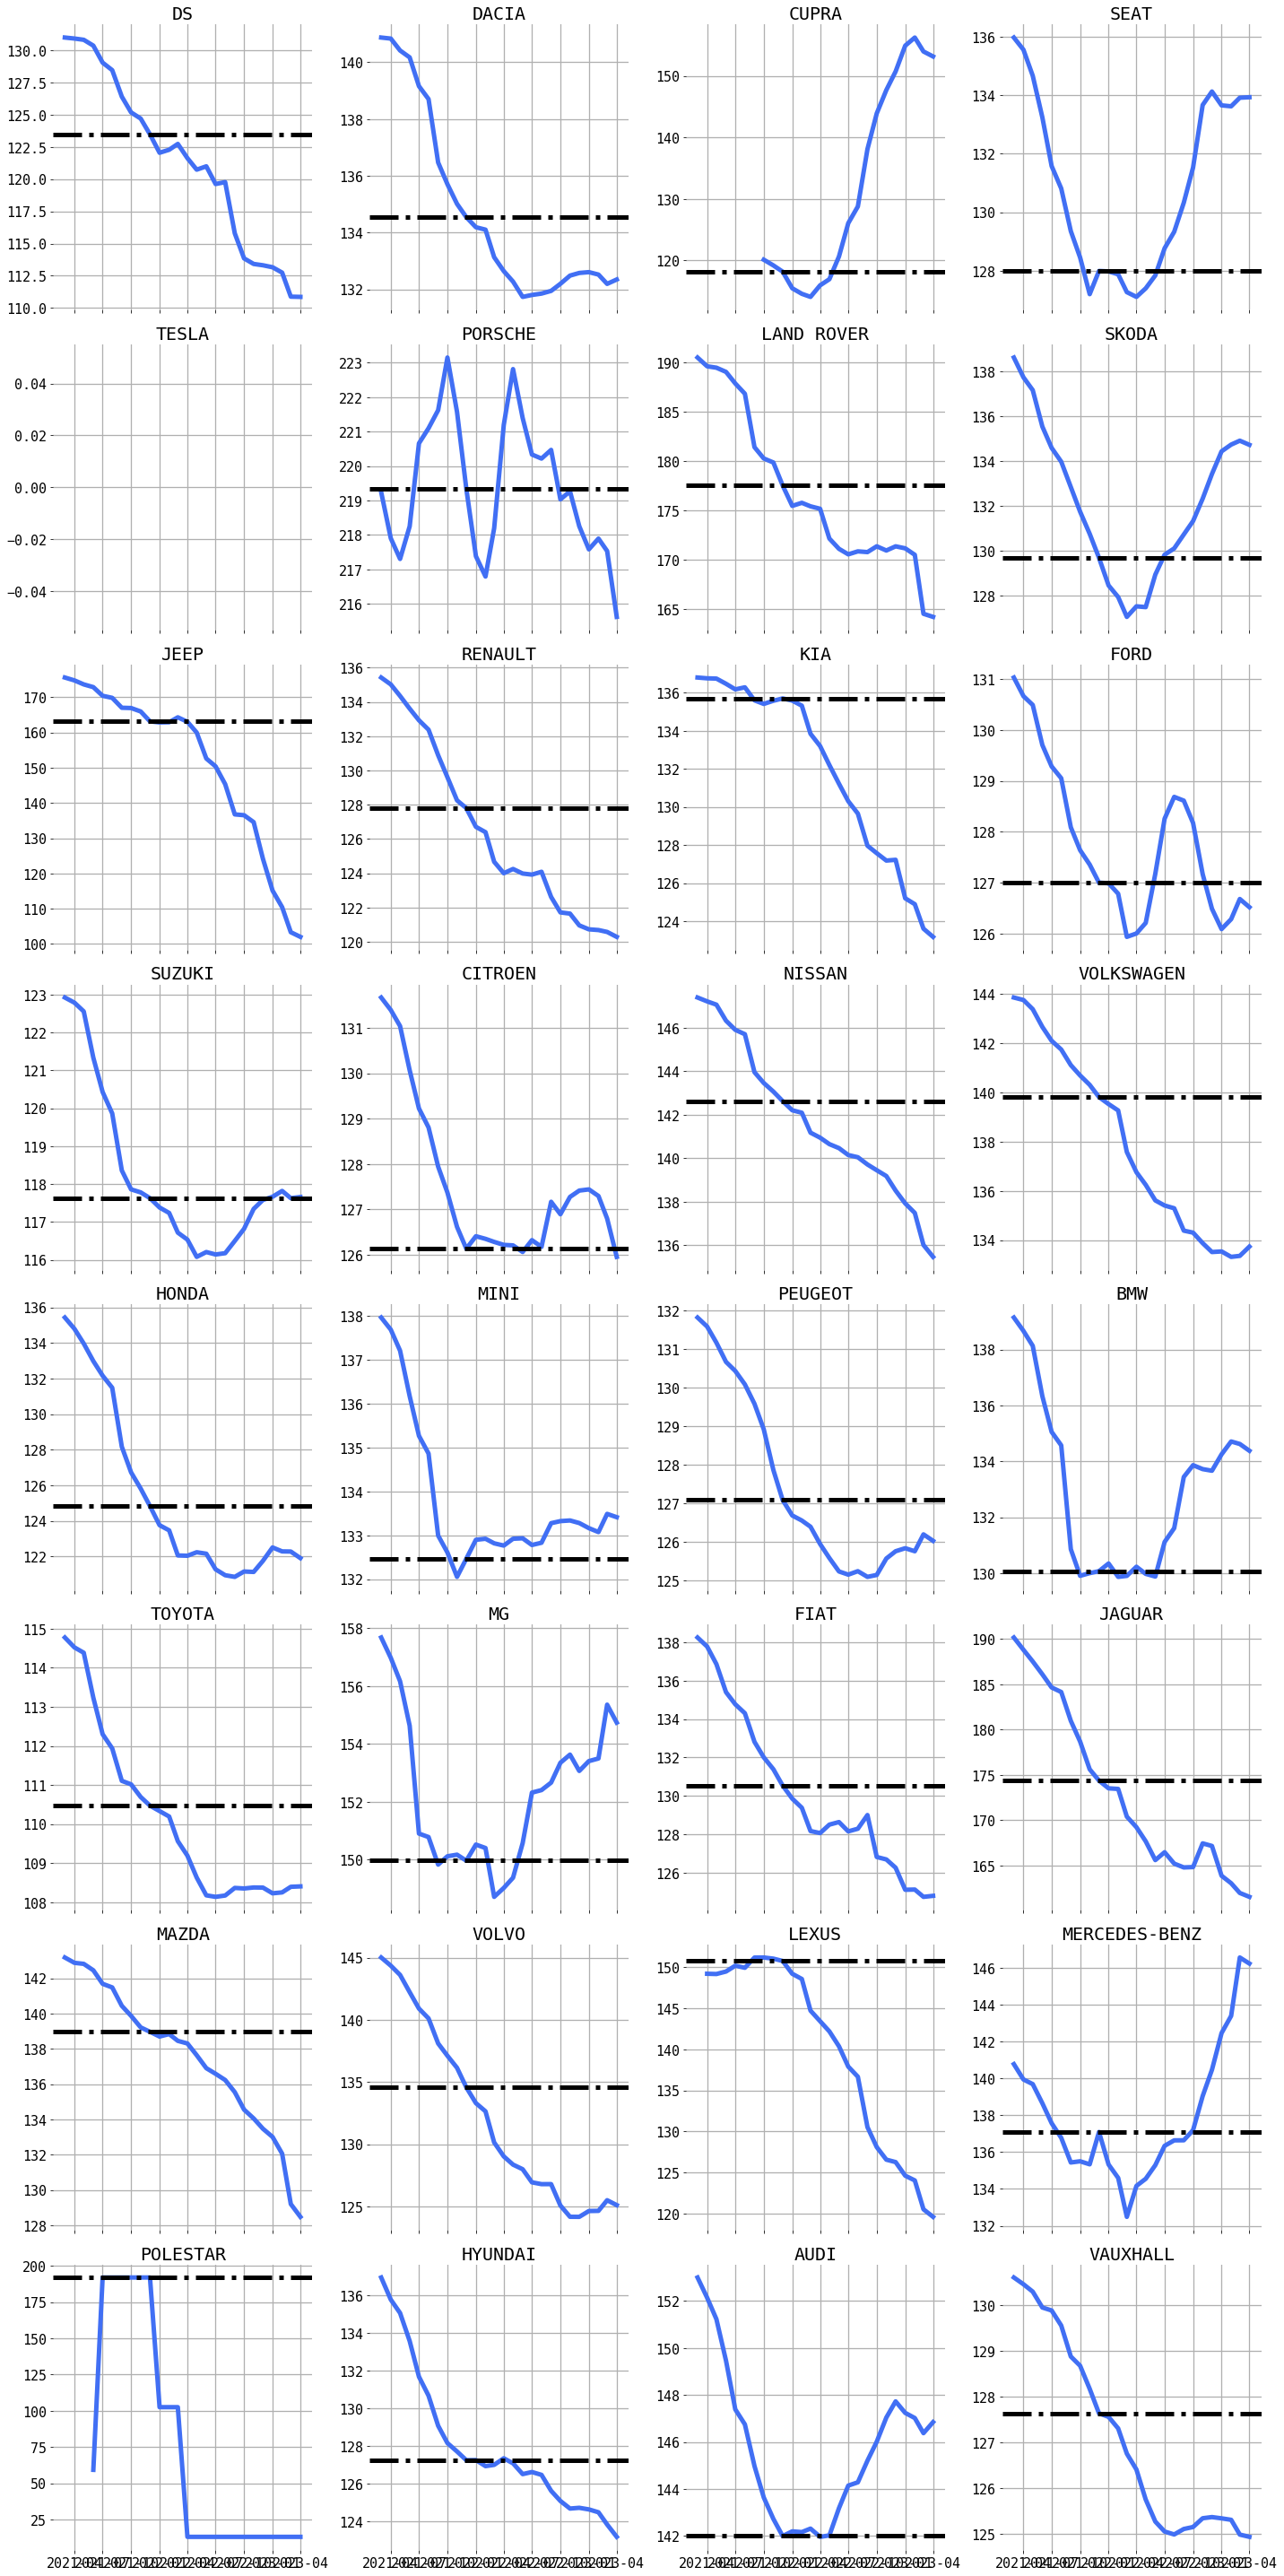

In [33]:
nrows = 8
ncols = 4

list_list_makes = []


fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20, 40), sharex=True)

# myLocator = mticker.MultipleLocator(4)

rows = list(range(0, nrows))
columns = list(range(0, ncols))

counter = 0
for row in rows:
    for column in columns:
        try:
            # print(counter)
            make = makes[row::nrows][column]
            ax[row, column].plot(ukevs[ukevs.make == make].set_index('monthOfFirstRegistration').mean_co2, label='{} CO2 Wales Performance'.format(make))
            # ax[row, column].plot(ukevs[ukevs.make == make].set_index('monthOfFirstRegistration').mean_co2, label='{} CO2 rUK Performance'.format(make))
            ax[row, column].set_title(make)
            
            ax[row, column].axhline((targets[targets.make == make].co2Target.tolist()[0]), linestyle='dashdot', color='black', label='{} CO2 Target'.format(make))
            # ax[row, column].legend()
            # ax[row, column].xaxis.set_major_locator(myLocator)
        
        except Exception as e:
            print("Error with {m}: {e}".format(m=counter, e=e))
        
        counter += 1
    counter += 1    
    
# fig.legend()
fig.tight_layout()

# plt.savefig('plots/wales_uk_co2.png', transparent=True, bbox_inches='tight', dpi=300)

## Carbon rating of new cars & vans

In [65]:
%%bigquery c2r --project rugged-baton-283921
SELECT monthOfFirstRegistration, fuelType, AVG(co2Emissions) as meanCo2
FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'

AND fuelType IN ('PETROL', 'DIESEL', 'HYBRID ELECTRIC')
AND monthOfFirstRegistration > '2020-04-01'
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
GROUP BY monthOfFirstRegistration, FuelType

Downloading: 100%|██████████| 108/108 [00:01<00:00, 79.85rows/s]


In [66]:
# c2r['fuelType'] = c2r.fuelType.apply(ft_cleaner)

In [67]:
c2r['monthOfFirstRegistration'] = pd.to_datetime(c2r.monthOfFirstRegistration)
c2r = c2r.pivot(index='monthOfFirstRegistration', columns='fuelType', values='meanCo2')
c2r.columns = [x.title() for x in c2r.columns]

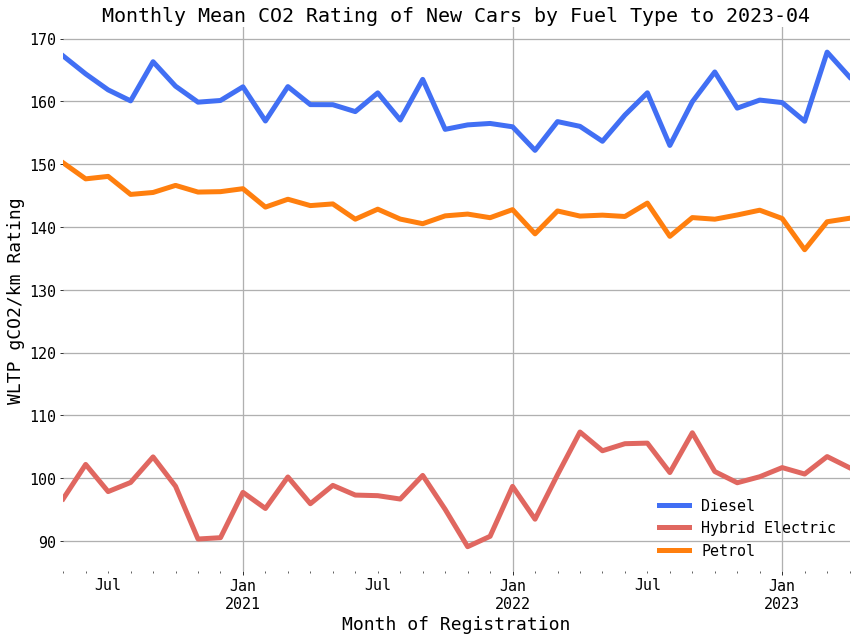

In [92]:
fig, ax = plt.subplots()

c2r.plot(ax=ax)

ax.set_title('Monthly Mean CO2 Rating of New Cars by Fuel Type to {}'.format(last_month))
ax.set_ylabel('WLTP gCO2/km Rating')
ax.set_xlabel('Month of Registration')

plt.savefig('plots/mean_co2_fueltype_{}.png'.format(this_month), transparent=False, bbox_inches='tight', dpi=300, facecolor='white')

In [89]:
%%bigquery wei --project rugged-baton-283921
SELECT monthOfFirstRegistration, fuelType, AVG(revenueWeight) as meanCo2
FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'

AND fuelType IN ('PETROL', 'DIESEL', 'HYBRID ELECTRIC', 'ELECTRICITY')
AND monthOfFirstRegistration > '2020-04-01'
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
GROUP BY monthOfFirstRegistration, FuelType

Downloading: 100%|██████████| 144/144 [00:01<00:00, 96.75rows/s] 


In [90]:
wei['monthOfFirstRegistration'] = pd.to_datetime(wei.monthOfFirstRegistration)
wei = wei.pivot(index='monthOfFirstRegistration', columns='fuelType', values='meanCo2')
wei.columns = [x.title() for x in wei.columns]

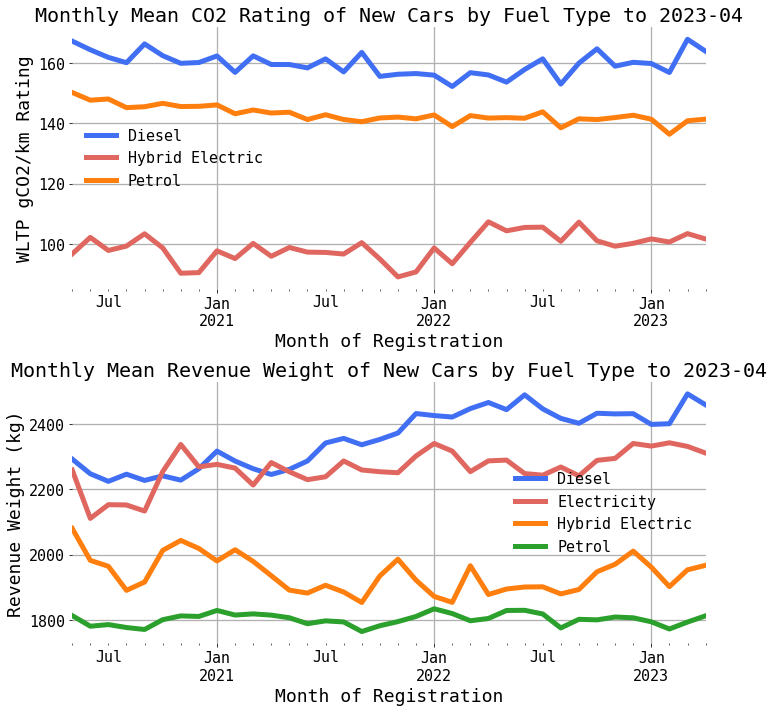

In [91]:
fig, ax = plt.subplots(2, figsize=(10, 10))

c2r.plot(ax=ax[0])
wei.plot(ax=ax[1])

ax[0].set_title('Monthly Mean CO2 Rating of New Cars by Fuel Type to {}'.format(last_month))
ax[0].set_ylabel('WLTP gCO2/km Rating')
ax[0].set_xlabel('Month of Registration')

ax[1].set_title('Monthly Mean Revenue Weight of New Cars by Fuel Type to {}'.format(last_month))
ax[1].set_ylabel('Revenue Weight (kg)')
ax[1].set_xlabel('Month of Registration')

plt.savefig('plots/mean_co2_fueltype_{}.png'.format(this_month), transparent=False, bbox_inches='tight', dpi=300, facecolor='white')